In [1]:
:ext FlexibleContexts
:ext GADTs

In [20]:
import qualified Data.ByteString.Lazy as BS
import qualified Data.ByteString as SBS
import Data.Word
import Control.Lens ((^.), (^?), ix)
import qualified Data.Vector as V
import qualified Data.Vector.Storable as SV
import qualified Data.Vector.Unboxed as UV
import qualified Data.Aeson as Aeson
import qualified Data.Array.Repa as RP
import Data.Array.Repa ((:.)(..), Z(..))
import qualified Data.Array.Repa.Repr.ForeignPtr as RF
import qualified Codec.Picture as JP
import qualified Codec.Picture.Repa as RPJ
import qualified Codec.Picture.Types as JP
import qualified Codec.Picture.Drawing as JP
import qualified Data.Store as Store
import Control.Exception.Base
import IHaskell.Display.Juicypixels hiding (Image)

import MXNet.Coco.Mask
import MXNet.Coco.Types
import MXNet.Coco.Index

In [21]:
load path = do
    bs <- SBS.readFile path
    Store.decodeIO bs

store path obj = do 
    SBS.writeFile path (Store.encode obj)
    return obj

In [22]:
data Y8

class ToDynamicImage a where
    toDynamicImage :: Img a -> JP.DynamicImage

instance ToDynamicImage Y8 where
    toDynamicImage (Img arr0) = JP.ImageY8 $ JP.Image w h (SV.unsafeFromForeignPtr0 (RF.toForeignPtr arr) (h*w*z) )
      where 
        (Z :. h :. w :. z) = RP.extent arr
        arr = RP.computeS arr0 

In [5]:
anns <- load "../anns.store" :: IO (V.Vector Annotation)
imgs <- load "../imgs.store" :: IO (V.Vector Image)

(558840,(199.84,200.46,77.71,70.88))

((Z :. 1) :. 640) :. 427

((Z :. 427) :. 640) :. 1

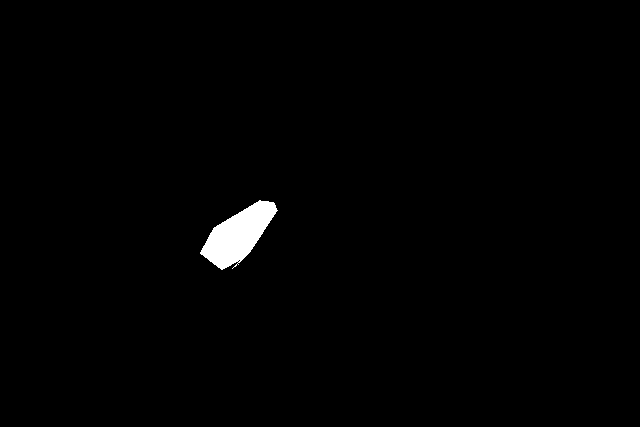

In [23]:
anno = V.head anns 
(anno ^. ann_image_id, anno ^. ann_bbox)
SegPolygon polys = anno ^. ann_segmentation
crle <- frPoly (map SV.fromList polys) 427 640
mask <- decode crle
RP.extent mask
maskHW = RP.backpermute (Z :. 427 :. 640 :. 1) (\ (Z :. c :. w :. h) -> Z :. h :. w :. c) mask
RP.extent maskHW
img = toDynamicImage (Img $ RP.map (*255) maskHW :: Img Y8)
JP.convertRGB8 img

In [24]:
imgHeatmap = RPJ.convertImage img :: RPJ.Img RPJ.RGBA

In [25]:
theImg = V.head $ V.filter ( (== anno ^. ann_image_id) . (^. img_id)) imgs
theImgPath = "/home/jiasen/dschungel/coco/train2017/" ++ theImg ^. img_file_name
Right imgRaw <- RPJ.readImageRGBA theImgPath

In [26]:
imgBlend = RP.zipWith (\u0 u1 -> floor $ fromIntegral u0 * 0.4 + fromIntegral u1 * 0.6) (imgData imgHeatmap) (imgData imgRaw)

In [27]:
mutableBlendImg <- JP.thawImage $ JP.convertRGB8 $ imgToImage (Img imgBlend)

In [28]:
(x0, y0, w0, h0) = anno ^. ann_bbox
x1 = x0 + w0
y1 = y0 + h0
JP.drawRectangle mutableBlendImg (floor x0) (floor y0) (floor x1) (floor y1) (JP.PixelRGB8 0 0 255)

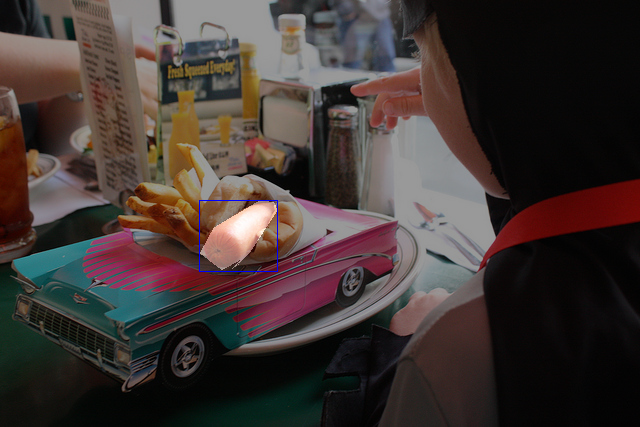

In [31]:
imgWithBB <- JP.freezeImage mutableBlendImg
imgWithBB

In [ ]:
-- build mapping: image -> [annotation]

In [6]:
import GHC.Stats
getRTSStats

RTSStats {gcs = 7910, major_gcs = 13, allocated_bytes = 8878196800, max_live_bytes = 2105412240, max_large_objects_bytes = 512744560, max_compact_bytes = 0, max_slop_bytes = 6489456, max_mem_in_use_bytes = 3765436416, cumulative_live_bytes = 4266035912, copied_bytes = 8682854800, par_copied_bytes = 0, cumulative_par_max_copied_bytes = 0, cumulative_par_balanced_copied_bytes = 0, mutator_cpu_ns = 2559867000, mutator_elapsed_ns = 15979164476, gc_cpu_ns = 3699374000, gc_elapsed_ns = 4406662659, cpu_ns = 6259241000, elapsed_ns = 20385827135, gc = GCDetails {gcdetails_gen = 0, gcdetails_threads = 1, gcdetails_allocated_bytes = 1052904, gcdetails_live_bytes = 3576422184, gcdetails_large_objects_bytes = 588047824, gcdetails_compact_bytes = 0, gcdetails_slop_bytes = 32559320, gcdetails_mem_in_use_bytes = 3765436416, gcdetails_copied_bytes = 42696, gcdetails_par_max_copied_bytes = 0, gcdetails_par_balanced_copied_bytes = 0, gcdetails_sync_elapsed_ns = 7135, gcdetails_cpu_ns = 78000, gcdetails_e

In [39]:
a = RP.fromListUnboxed (Z :. (2 :: Int) :. (2 :: Int)) [1,2,3,4]
b = RP.fromListUnboxed (Z :. (2 :: Int) :. (2 :: Int)) [4,3,2,1]

In [40]:
:ext PartialTypeSignatures

In [41]:
c <- RP.computeP $ a RP.+^ b :: IO (RP.Array RP.U _ _)

In [42]:
c

AUnboxed ((Z :. 2) :. 2) [5.0,5.0,5.0,5.0]